In [1]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import cv2
import glob
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Read Image List

In [2]:
images = [cv2.resize(cv2.imread(file,cv2.IMREAD_GRAYSCALE)/255, (224, 224)).astype('float32')  for file in glob.glob("Train/*")]
images_label = [float(file.split("/")[1].split("_")[0])-1 for file in glob.glob("Train/*")]

<IPython.core.display.Javascript object>


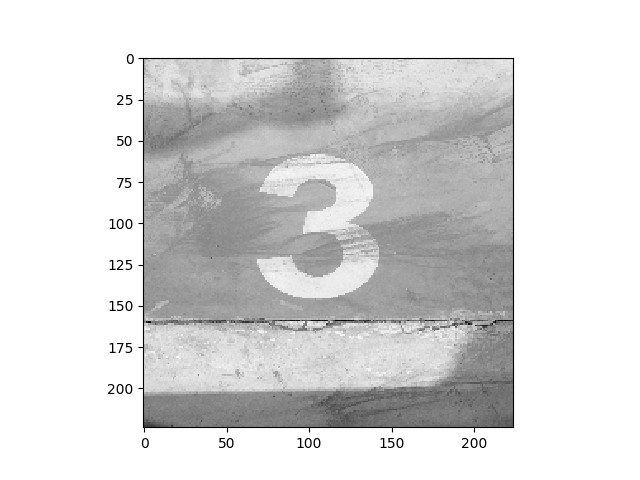

In [4]:
%matplotlib notebook
plt.imshow(images[0], cmap="gray")
plt.show()

# Trainning

In [14]:
batch_size = 128
num_classes = 14
epochs = 1000

# input image dimensions
img_rows, img_cols = 224, 224

x_train = np.array(images)
y_train = np.array(images_label)

# the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,)
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

x_train shape: (47, 224, 224, 1)
47 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               99123328  
_________________________________________________________________
dropout_10 (Dropout)      

Epoch 71/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.6977 - acc: 0.8085
Epoch 72/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.5792 - acc: 0.8085
Epoch 73/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.5209 - acc: 0.9362
Epoch 74/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.3740 - acc: 0.9787
Epoch 75/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.5241 - acc: 0.8511
Epoch 76/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.5921 - acc: 0.8298
Epoch 77/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.4799 - acc: 0.8511
Epoch 78/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.3198 - acc: 0.9362
Epoch 79/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.3613 - acc: 0.9149
Epoch 80/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.3909 - acc: 0.8936
Epoch 81/1000
47/47 [=========

Epoch 155/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1154 - acc: 0.9787
Epoch 156/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1043 - acc: 0.9787
Epoch 157/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1199 - acc: 0.9574
Epoch 158/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1484 - acc: 0.9787
Epoch 159/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1699 - acc: 0.9574
Epoch 160/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0414 - acc: 1.0000
Epoch 161/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1601 - acc: 0.9574
Epoch 162/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0649 - acc: 1.0000
Epoch 163/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1067 - acc: 0.9787
Epoch 164/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.2217 - acc: 0.9362
Epoch 165/1000
47/47

Epoch 239/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1078 - acc: 0.9574
Epoch 240/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0846 - acc: 0.9787
Epoch 241/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0728 - acc: 0.9787
Epoch 242/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0627 - acc: 0.9574
Epoch 243/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0628 - acc: 0.9787
Epoch 244/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0671 - acc: 0.9787
Epoch 245/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1008 - acc: 0.9787
Epoch 246/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1116 - acc: 0.9574
Epoch 247/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0772 - acc: 0.9787
Epoch 248/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1153 - acc: 0.9574
Epoch 249/1000
47/47

Epoch 323/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1045 - acc: 0.9574
Epoch 324/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1218 - acc: 0.9362
Epoch 325/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0549 - acc: 0.9787
Epoch 326/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0223 - acc: 1.0000
Epoch 327/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.2012 - acc: 0.9149
Epoch 328/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1039 - acc: 0.9574
Epoch 329/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0246 - acc: 1.0000
Epoch 330/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0343 - acc: 1.0000
Epoch 331/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0674 - acc: 0.9787
Epoch 332/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0285 - acc: 1.0000
Epoch 333/1000
47/47

Epoch 407/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0303 - acc: 1.0000
Epoch 408/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0424 - acc: 0.9787
Epoch 409/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0793 - acc: 0.9574
Epoch 410/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0797 - acc: 0.9574
Epoch 411/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0933 - acc: 0.9574
Epoch 412/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0085 - acc: 1.0000
Epoch 413/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0839 - acc: 0.9787
Epoch 414/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1485 - acc: 0.9574
Epoch 415/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1116 - acc: 0.9574
Epoch 416/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0526 - acc: 0.9787
Epoch 417/1000
47/47

Epoch 491/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0883 - acc: 0.9787
Epoch 492/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0344 - acc: 0.9787
Epoch 493/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0555 - acc: 0.9787
Epoch 494/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0269 - acc: 1.0000
Epoch 495/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0088 - acc: 1.0000
Epoch 496/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0279 - acc: 0.9787
Epoch 497/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0549 - acc: 0.9574
Epoch 498/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0223 - acc: 1.0000
Epoch 499/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0470 - acc: 0.9787
Epoch 500/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0613 - acc: 0.9787
Epoch 501/1000
47/47

Epoch 575/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0090 - acc: 1.0000
Epoch 576/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0034 - acc: 1.0000
Epoch 577/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.1539 - acc: 0.9574
Epoch 578/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0410 - acc: 0.9787
Epoch 579/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0403 - acc: 0.9787
Epoch 580/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0213 - acc: 1.0000
Epoch 581/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0852 - acc: 0.9574
Epoch 582/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0714 - acc: 0.9787
Epoch 583/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0365 - acc: 1.0000
Epoch 584/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0690 - acc: 0.9787
Epoch 585/1000
47/47

Epoch 659/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0426 - acc: 0.9787
Epoch 660/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0374 - acc: 0.9787
Epoch 661/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0063 - acc: 1.0000
Epoch 662/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0418 - acc: 0.9787
Epoch 663/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0074 - acc: 1.0000
Epoch 664/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0040 - acc: 1.0000
Epoch 665/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0044 - acc: 1.0000
Epoch 666/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0205 - acc: 1.0000
Epoch 667/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0270 - acc: 1.0000
Epoch 668/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0857 - acc: 0.9574
Epoch 669/1000
47/47

Epoch 743/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0339 - acc: 0.9787
Epoch 744/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0336 - acc: 1.0000
Epoch 745/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0169 - acc: 1.0000
Epoch 746/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0646 - acc: 0.9787
Epoch 747/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0732 - acc: 0.9574
Epoch 748/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0013 - acc: 1.0000
Epoch 749/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0449 - acc: 1.0000
Epoch 750/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0581 - acc: 0.9787
Epoch 751/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0708 - acc: 0.9787
Epoch 752/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0053 - acc: 1.0000
Epoch 753/1000
47/47

Epoch 827/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0011 - acc: 1.0000
Epoch 828/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0064 - acc: 1.0000
Epoch 829/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0032 - acc: 1.0000
Epoch 830/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0055 - acc: 1.0000
Epoch 831/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0121 - acc: 1.0000
Epoch 832/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0550 - acc: 0.9787
Epoch 833/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0619 - acc: 0.9574
Epoch 834/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0143 - acc: 1.0000
Epoch 835/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0029 - acc: 1.0000
Epoch 836/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0041 - acc: 1.0000
Epoch 837/1000
47/47

Epoch 911/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0385 - acc: 0.9787
Epoch 912/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0047 - acc: 1.0000
Epoch 913/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0460 - acc: 0.9787
Epoch 914/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0080 - acc: 1.0000
Epoch 915/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0574 - acc: 0.9787
Epoch 916/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0279 - acc: 0.9787
Epoch 917/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0128 - acc: 1.0000
Epoch 918/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0191 - acc: 1.0000
Epoch 919/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0206 - acc: 1.0000
Epoch 920/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0084 - acc: 1.0000
Epoch 921/1000
47/47

Epoch 995/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0034 - acc: 1.0000
Epoch 996/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0248 - acc: 0.9787
Epoch 997/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0521 - acc: 0.9787
Epoch 998/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0129 - acc: 1.0000
Epoch 999/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0076 - acc: 1.0000
Epoch 1000/1000
47/47 [==============================] - 1s 14ms/step - loss: 0.0125 - acc: 1.0000


In [15]:
import random 

5


5


In [44]:
model.save_weights("AmasModel.h5")

# Test

In [ ]:
# build model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.load_weights("AmasModel.h5")

In [52]:
#random choose image
num = random.randint(0,47)
img = images[num]
lab = images_label[num]
print("truth: {}".format(int(lab+1)))
n_img = np.expand_dims(img,axis=0)
n_img = np.expand_dims(n_img,axis=-1)
prob = model.predict(n_img)
print("prob: {}".format(prob))
pred = np.argmax(prob) +1
print("pred: {}".format(int(pred)))

truth: 4
prob: [[  4.27466451e-10   2.78252332e-09   8.38433056e-09   9.99999642e-01
    4.49117757e-11   3.81451704e-10   2.79269699e-07   2.01538608e-08
    4.36087694e-11   1.78721882e-09   7.73742492e-09   6.82460061e-11
    1.46972310e-08   2.84847892e-11]]
pred: 4
